## Data viewing

## Dataset Exploration

Using `code/scan_inventory.py` we have already verified none of the 60 files are corrupt. The spacings (spacial resolution) are consistent between image and corresponding mask, the shapes also match. However, as the dataset authors said, the spacings are not the same between the images.

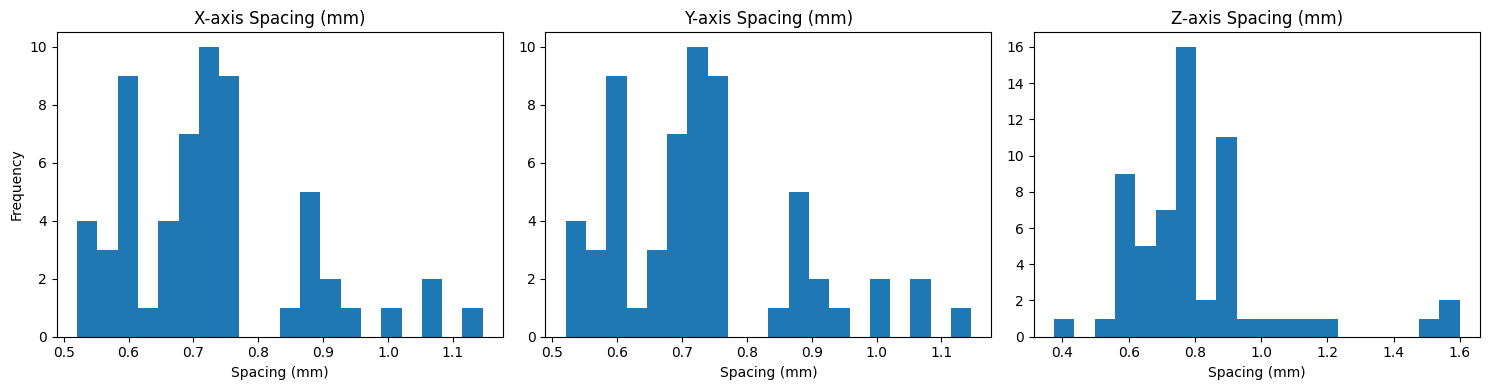

In [1]:
# 1. Load libraries
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Plotting
%matplotlib inline

# 2. Read the inventory CSV
df = pd.read_csv('/home/ragibabdi127/ms_thesis/logs/inventory.csv')

# 3. Extract spacing columns
x_spacing = df['spacing_x']
y_spacing = df['spacing_y']
z_spacing = df['spacing_z']

# 4. Plot histograms
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].hist(x_spacing, bins=20)
axes[0].set_title('X-axis Spacing (mm)')
axes[0].set_xlabel('Spacing (mm)')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_spacing, bins=20)
axes[1].set_title('Y-axis Spacing (mm)')
axes[1].set_xlabel('Spacing (mm)')

axes[2].hist(z_spacing, bins=20)
axes[2].set_title('Z-axis Spacing (mm)')
axes[2].set_xlabel('Spacing (mm)')

plt.tight_layout()
plt.show()

Since the spacing is spread out, **we should resample the data** for good performance. Spacing of 0.75mm seems very numerous across all axes. So perhaps **resampling at 0.75mm spacing** would be good idea.

Next, we check out if the masks are alligned properly along the three anatomical planes.

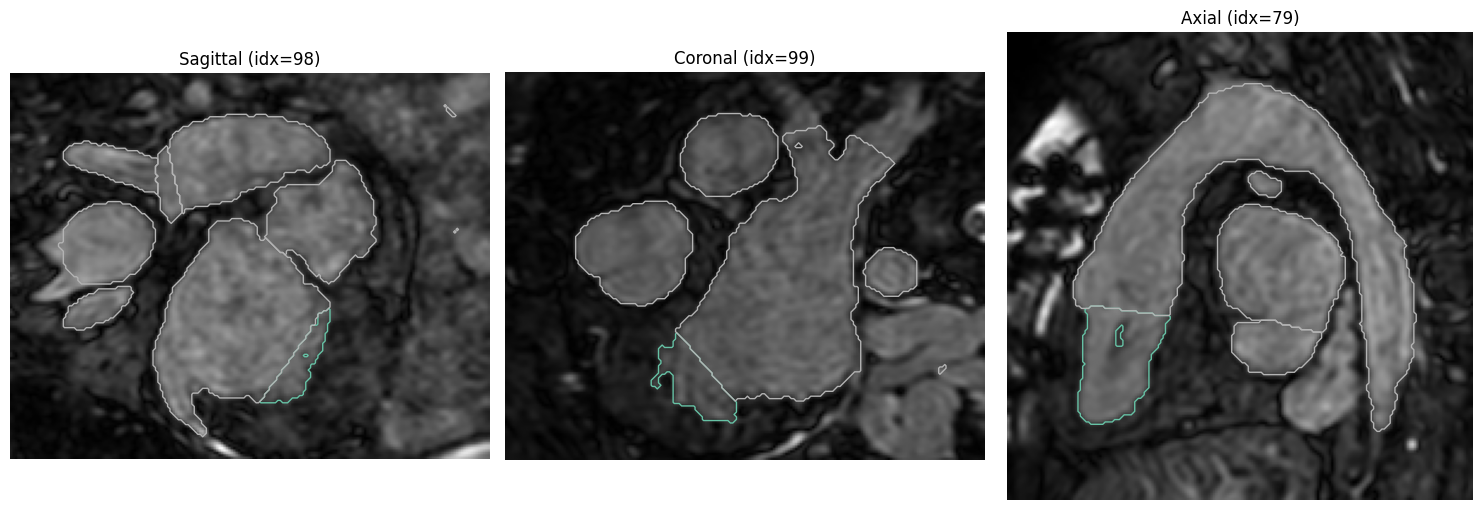

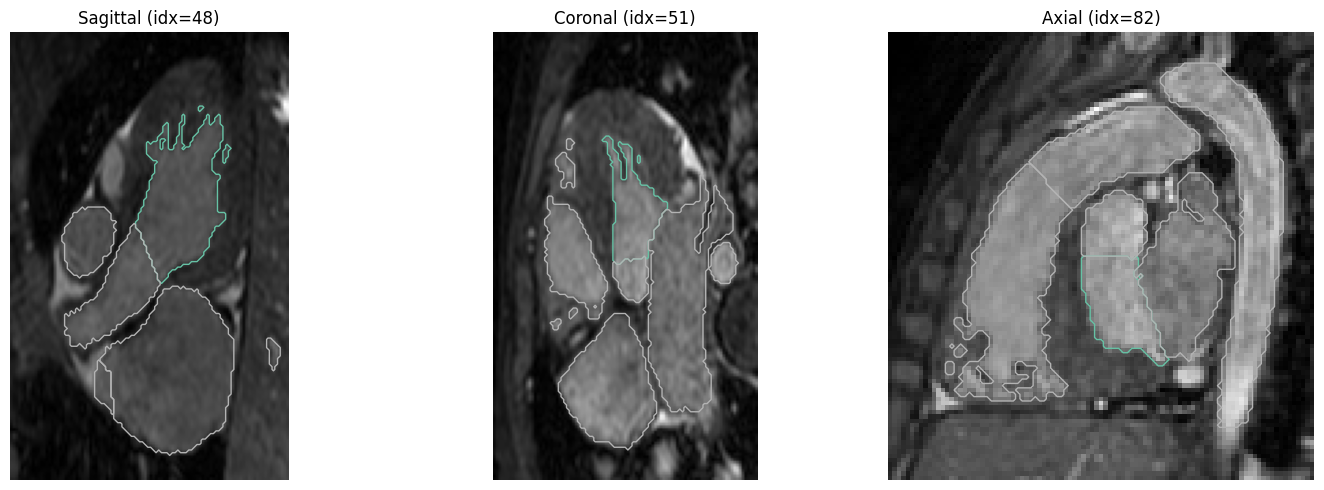

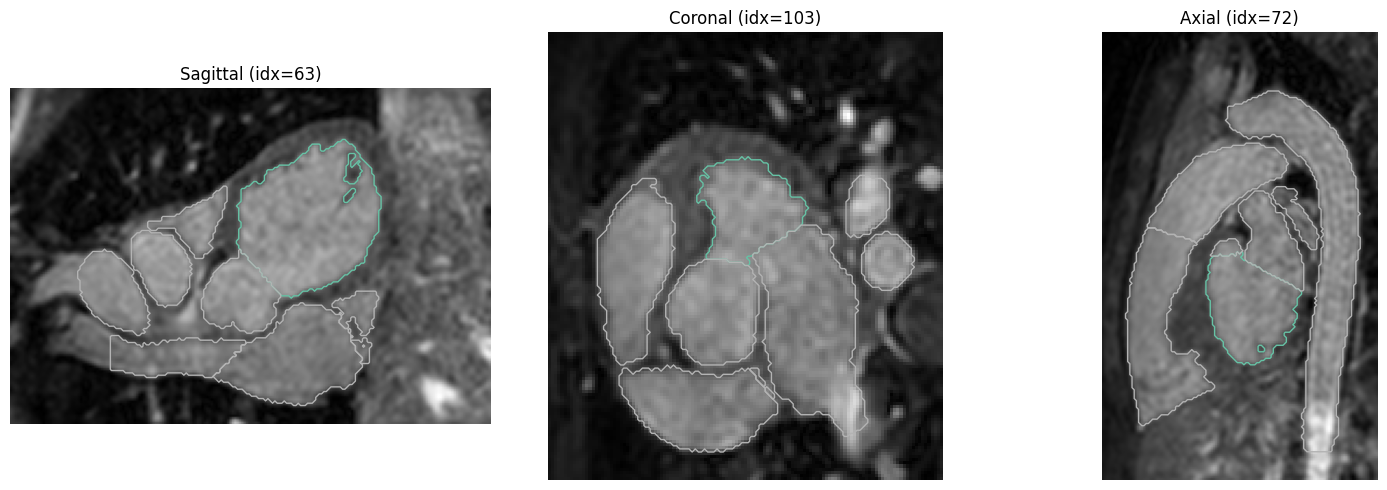

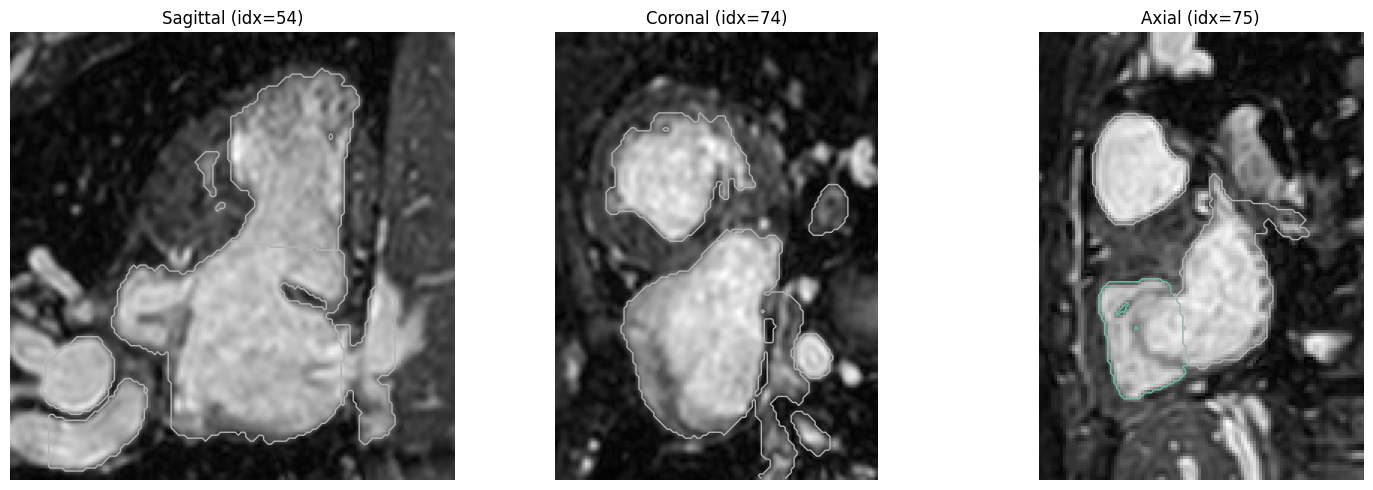

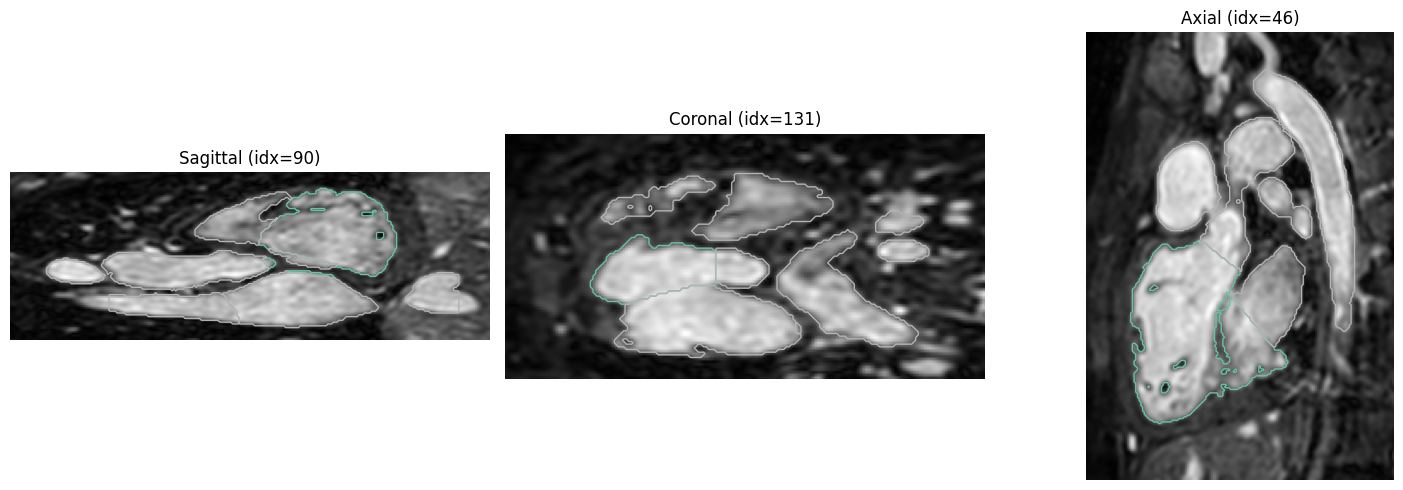

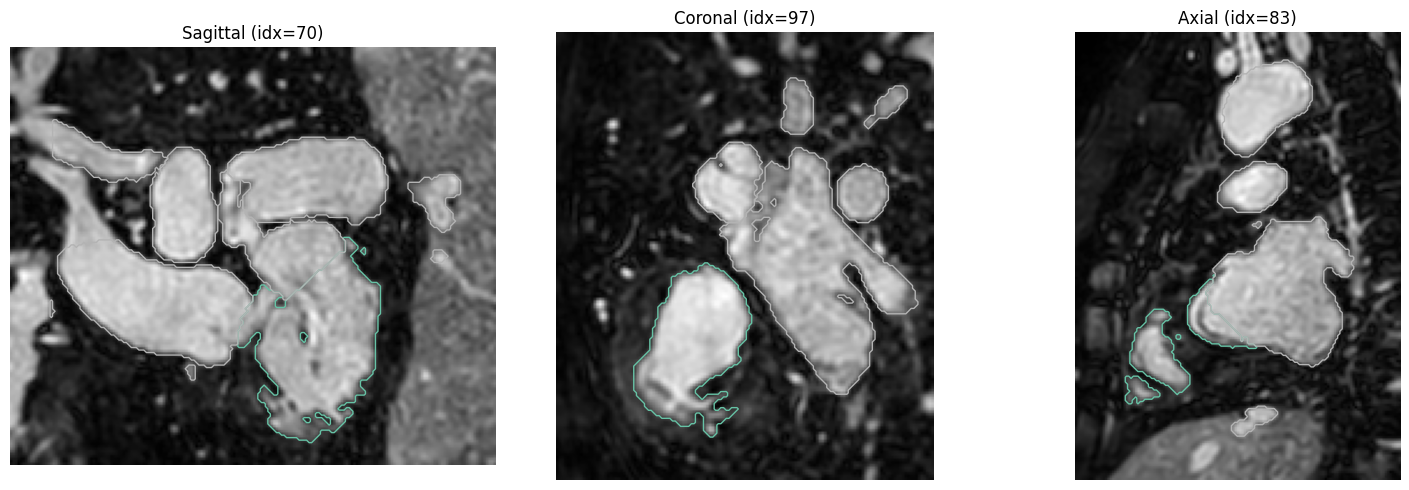

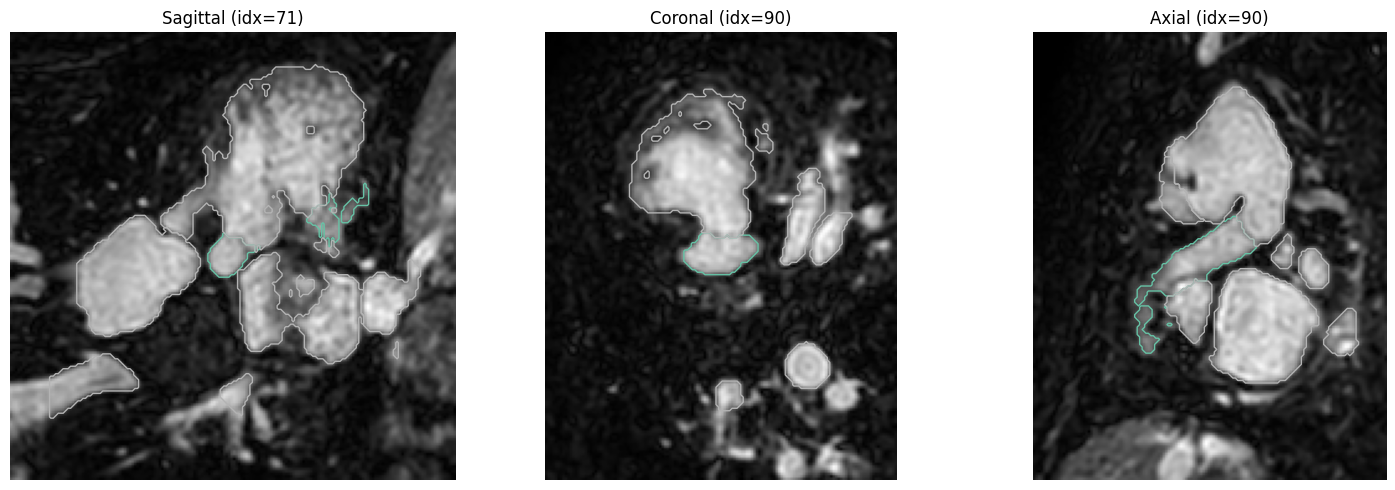

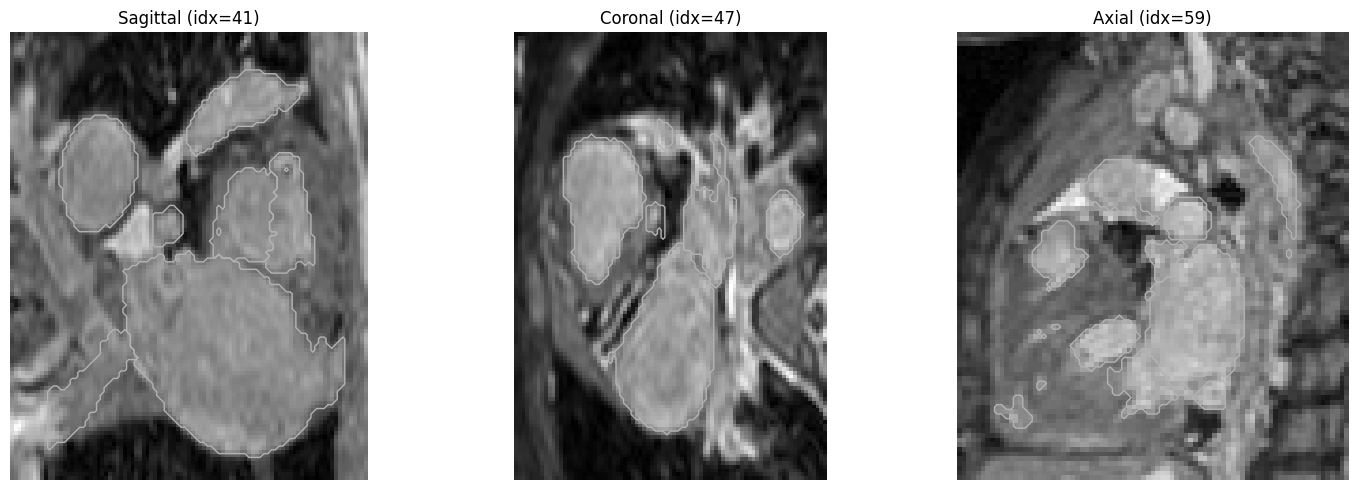

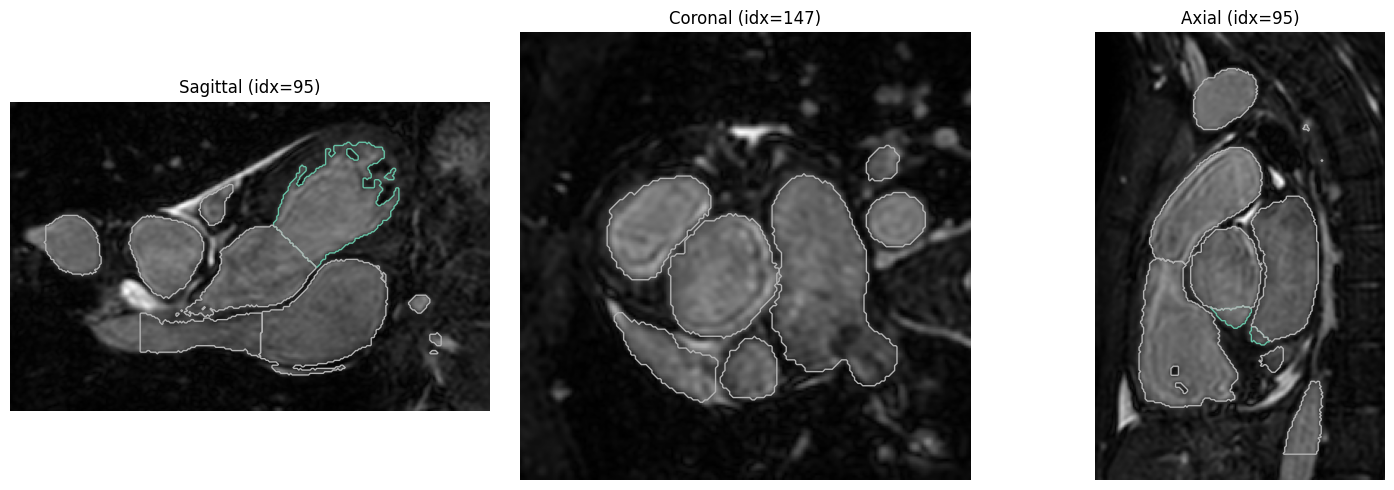

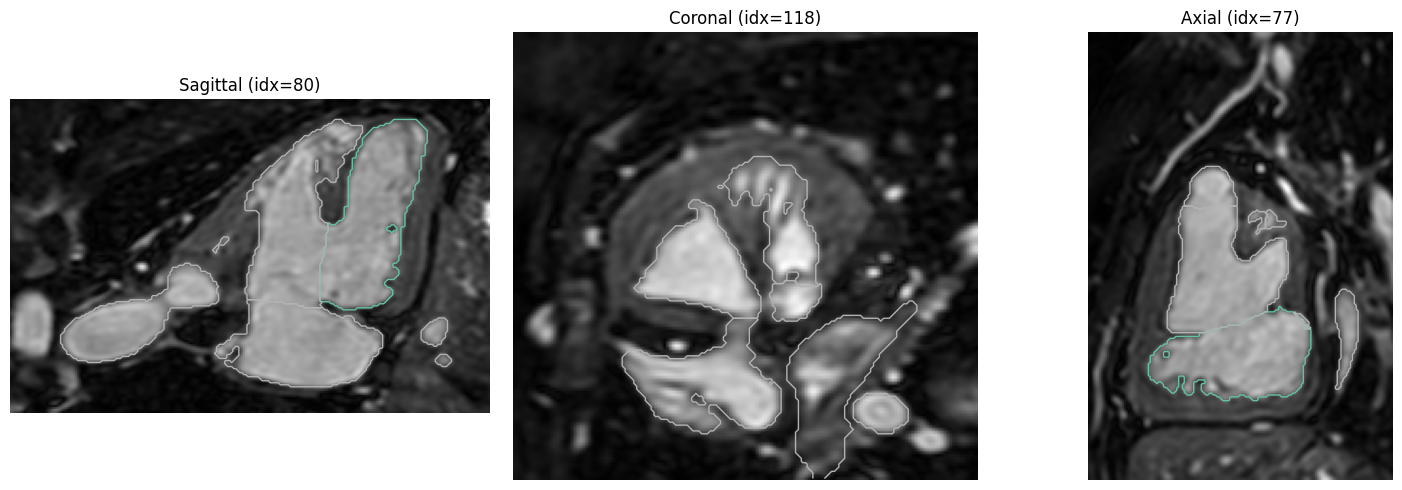

In [8]:
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random

num_labels = 8
cmap = plt.get_cmap('Set2', num_labels)

# 1. Gather all image paths
image_paths = sorted(glob.glob('/home/ragibabdi127/ms_thesis/cropped_norm/cropped_norm/*_cropped_norm.nii.gz'))
selected_img_paths = random.sample(image_paths, 10)

for img_path in selected_img_paths:
    # 2. Derive mask path from image filename
    seg_path = img_path.replace('_cropped_norm.nii.gz', '_cropped_seg.nii.gz')
    if not glob.os.path.exists(seg_path):
        print(f"Skipping {img_path}: no matching mask.")
        continue

    # 3. Load volumes
    img_vol = nib.load(img_path).get_fdata()
    seg_vol = nib.load(seg_path).get_fdata()

    # 4. Compute mid‐slice indices
    ix = img_vol.shape[0] // 2  # sagittal
    iy = img_vol.shape[1] // 2  # coronal
    iz = img_vol.shape[2] // 2  # axial

    # 5. Extract 2D slices
    sag_img, sag_mask = img_vol[ix, :, :], seg_vol[ix, :, :]
    cor_img, cor_mask = img_vol[:, iy, :], seg_vol[:, iy, :]
    ax_img,  ax_mask  = img_vol[:, :, iz], seg_vol[:, :, iz]

    # 6. Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, (plane, img_slice, mask_slice) in zip(axes, [
        ("Sagittal", sag_img, sag_mask),
        ("Coronal",  cor_img, cor_mask),
        ("Axial",    ax_img,  ax_mask),
    ]):
        ax.imshow(np.rot90(img_slice), cmap='gray', origin='lower')
        # draw contours for each label >0
        for lbl in np.unique(mask_slice):
            if lbl == 0: continue
            m = np.rot90(mask_slice == lbl)
            ax.contour(m, levels=[0.5], linewidths=1, colors=[cmap(lbl-1)])
        ax.set_title(f"{plane} (idx={ix if plane=='Sagittal' else iy if plane=='Coronal' else iz})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # 7. Wait for user
    input("Press Enter to view next volume…")
    plt.close(fig)

The labels seem to be well-alligned with the images.

Let's look at the intensity histograms. The following code snippet will save histograms of all the images in `logs/intensity_histograms` folder.

In [10]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure output directory exists
out_dir = '/home/ragibabdi127/ms_thesis/logs/intensity_histograms'
os.makedirs(out_dir, exist_ok=True)

# 2. Find all NIfTI files in the raw data folder
nii_files = glob.glob('/home/ragibabdi127/ms_thesis/cropped_norm/cropped_norm/*_cropped_norm.nii.gz')

# 3. Loop through each NIfTI file
for nii_path in nii_files:
    # a. Load the image volume and extract intensities
    img = nib.load(nii_path).get_fdata()
    intensities = img.ravel()

    # b. Plot the histogram of intensities
    plt.figure()
    plt.hist(intensities, bins=100)
    plt.title(os.path.basename(nii_path))
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    # c. Save the histogram figure
    fname = os.path.splitext(os.path.basename(nii_path))[0] + '_hist.png'
    plt.savefig(os.path.join(out_dir, fname))
    plt.close()

The histograms indicate the intensities of the images are skewed to the right, with next to nothing on the higher intensity spectrum. We will probably **need to do histogram equalization**.

According to `Quick guide on radiology image pre-processing for deep learning applications in prostate cancer research` (https://www.spiedigitallibrary.org/journals/journal-of-medical-imaging/volume-8/issue-01/010901/Quick-guide-on-radiology-image-pre-processing-for-deep-learning/10.1117/1.JMI.8.1.010901.full) MRI images need to be preprocessed in the following steps:
1. Denoising; usually handled by the machine itself
2. Bias Field Correction
3. Image registration (if needed)
4. Intensity Standardization (Histogram Equalization or Normalization)

In the dataset, no bias field correction was carried out, but scans with significant inhomogeneity in were removed, which has the same effect. During manual inspection, no scans were found that suggested bias field errors are present in the dataset. Therefore, we will skip Bias Field Correction. 

For image standardization, something similar to ROI based standardization was carried out so that blood pool has intensity of around 0.8, and lungs have mean intensity of 0.07. So, there is no explicit need for standardization. Z-score based normalization may be carried out, to make the intensities more comparable across scans. We will carry out tests to see what works best in terms of preserving contrast while making intensities more uniform.

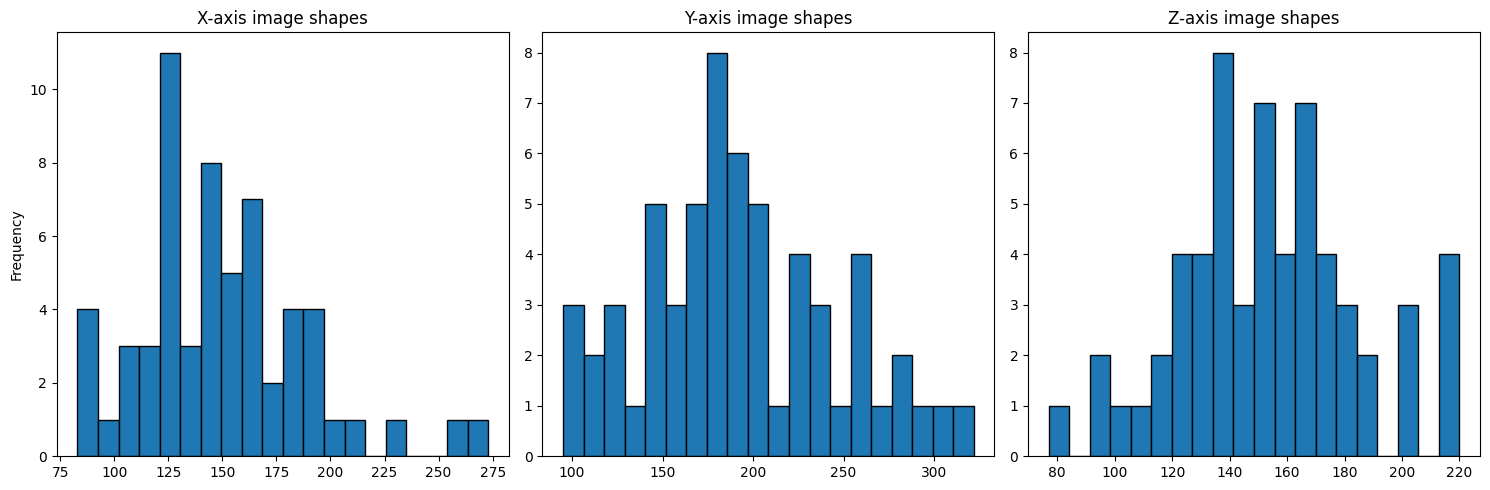

In [10]:
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# 1. Gather all .nii.gz files
nii_paths = glob.glob('/home/ragibabdi127/ms_thesis/cropped_norm/cropped_norm/*_cropped_norm.nii.gz')

# 2. Collect shapes
widths, heights, depths = [], [], []
for p in nii_paths:
    img = nib.load(p)
    x, y, z = img.shape  # shape = (X, Y, Z)
    widths .append(x)    # X-axis → Width
    heights.append(y)    # Y-axis → Height
    depths .append(z)    # Z-axis → Depth

# 3. Plot overlaid histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#bins = max(len(nii_paths)//2, 10)  # e.g. ~10–20 bins

axes[0].hist(widths, bins=20, label='Width (X)',  edgecolor='black')
axes[0].set_title('X-axis image shapes')
axes[0].set_ylabel('Frequency')

axes[1].hist(heights, bins=20, label='Height (Y)', edgecolor='black')
axes[1].set_title('Y-axis image shapes')

axes[2].hist(depths, bins=20, label='Depth (Z)',  edgecolor='black')
axes[2].set_title('Z-axis image shapes')

plt.tight_layout()
plt.show()

Choosing **128, 128, 128** as the most suitable size to resize images to; balancing resource usage and broad compatibility.

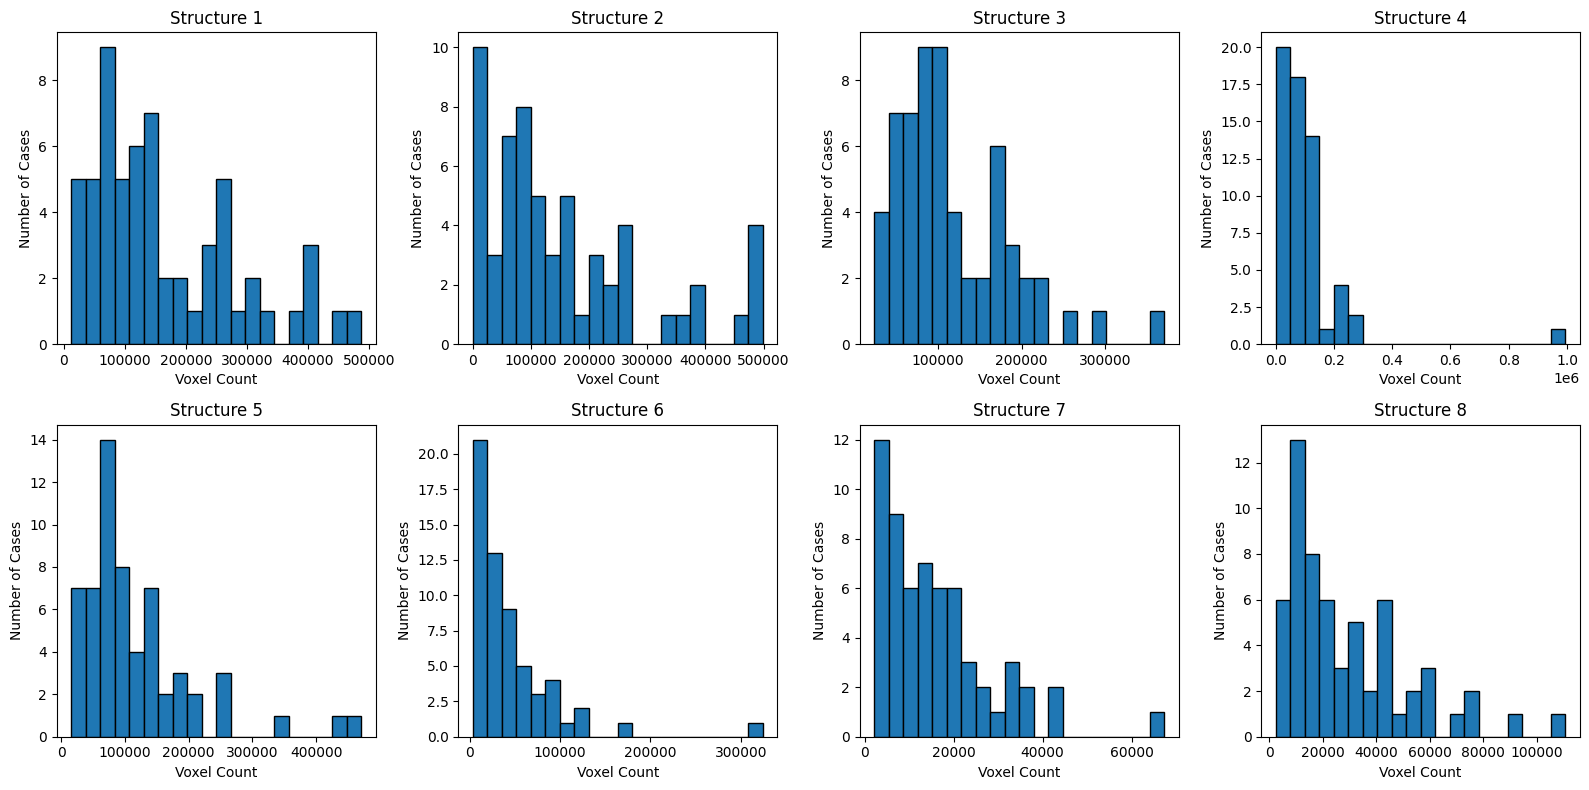

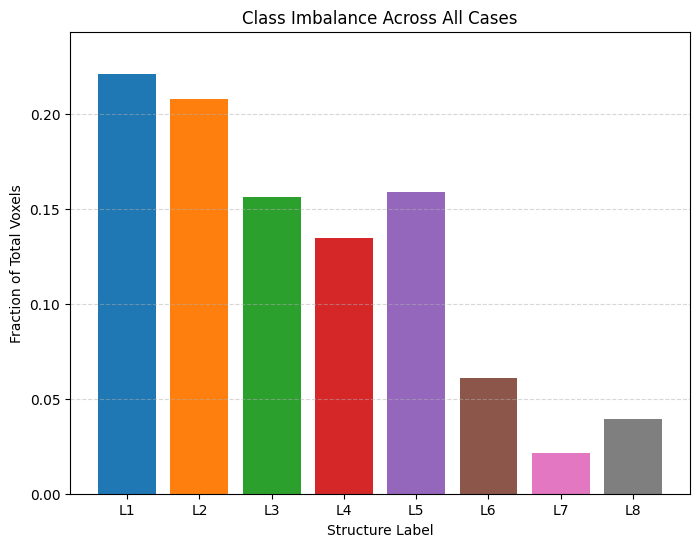

In [11]:
import glob
import nibabel as nib                    # NiBabel for NIfTI I/O :contentReference[oaicite:2]{index=2}
import numpy as np                       # NumPy for fast array ops :contentReference[oaicite:3]{index=3}
import matplotlib.pyplot as plt          # Matplotlib for plotting :contentReference[oaicite:4]{index=4}

# 2. Discover all segmentation masks
mask_paths = sorted(glob.glob('/home/ragibabdi127/ms_thesis/cropped_norm/cropped_norm/*_cropped_seg.nii.gz'))

# 3. Define labels (structures 1–8)
labels = list(range(1, 9))

# 4. Count voxels per label, per case
counts_per_case = []
for path in mask_paths:
    seg = nib.load(path).get_fdata()
    counts = [int(np.sum(seg == lbl)) for lbl in labels]
    counts_per_case.append(counts)
counts_arr = np.vstack(counts_per_case)  # shape = (num_cases, 8)

# 5. Total voxels per structure (for imbalance chart)
total_counts = counts_arr.sum(axis=0)
normalized = total_counts / total_counts.sum()  # fraction per class

# 6. Plot histogram of voxel counts for each structure
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
for i, lbl in enumerate(labels):
    axes[i].hist(counts_arr[:, i], bins=20, edgecolor='black')
    axes[i].set_title(f'Structure {lbl}')
    axes[i].set_xlabel('Voxel Count')
    axes[i].set_ylabel('Number of Cases')
plt.tight_layout()
plt.show()

# 7. Plot Dice-style class imbalance bar chart
plt.figure(figsize=(8, 6))
plt.bar([f'L{lbl}' for lbl in labels],
        normalized,
        color=plt.get_cmap('tab10')(range(len(labels))))  # discrete colors :contentReference[oaicite:5]{index=5}
plt.xlabel('Structure Label')
plt.ylabel('Fraction of Total Voxels')
plt.title('Class Imbalance Across All Cases')
plt.ylim(0, normalized.max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

From the class imbalance plot, we can see that labels 6, 7, 8 have a much smaller fraction of voxels. As such, some sort of **weighted loss**  function might be beneficial to balance out these classes. Examples include weighted cross-entropy, focal loss/Taversky loss, focal dice loss, etc. 

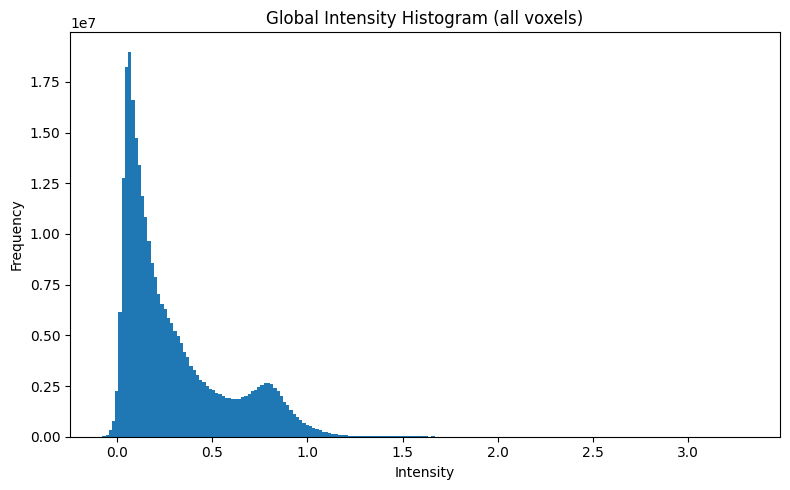

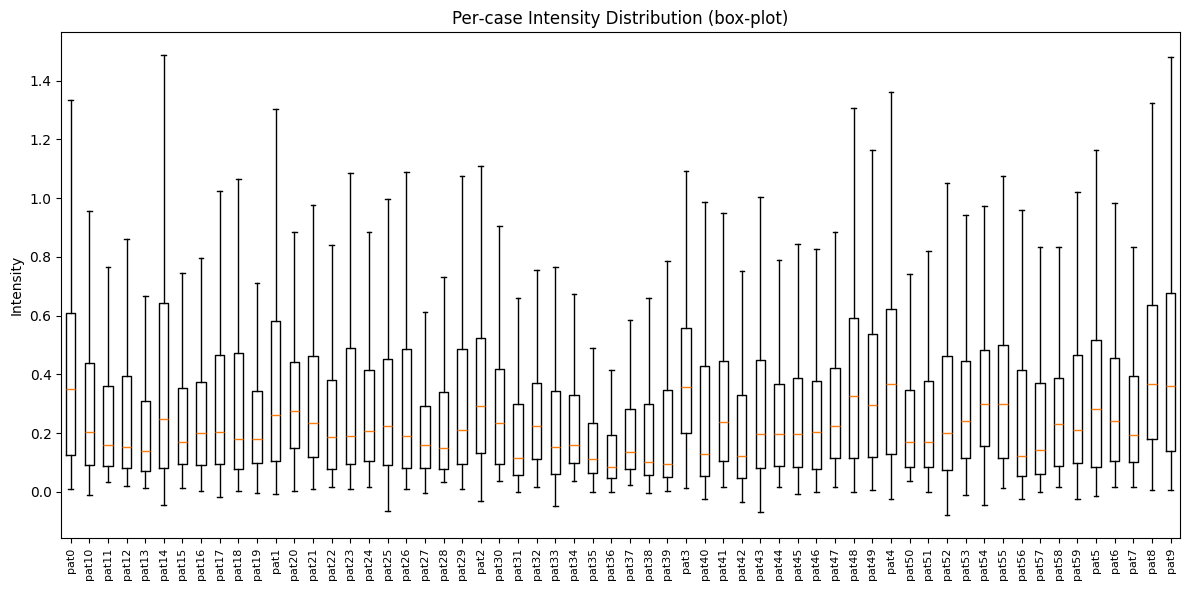

In [12]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# ensure output directory exists
out_dir = 'logs'
os.makedirs(out_dir, exist_ok=True)

# 2. Gather all normalized image paths
nii_paths = sorted(glob.glob('/home/ragibabdi127/ms_thesis/cropped_norm/cropped_norm/*_cropped_norm.nii.gz'))

# 3. Load and collect intensities
all_intensities = []
per_case_intensities = []

for p in nii_paths:
    data = nib.load(p).get_fdata().ravel()
    per_case_intensities.append(data)
    all_intensities.append(data)  # we'll concatenate later

# 4. Global histogram
plt.figure(figsize=(8,5))
plt.hist(np.concatenate(all_intensities), bins=200)
plt.title('Global Intensity Histogram (all voxels)')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'global_intensity_histogram.png'))
plt.show()

# 5. Per‐case box‐plot
plt.figure(figsize=(12,6))
plt.boxplot(per_case_intensities, showfliers=False)
# label with patient IDs (basename without extension)
labels = [os.path.basename(p).replace('_cropped_norm.nii.gz','') for p in nii_paths]
plt.xticks(range(1, len(labels)+1), labels, rotation=90, fontsize=8)
plt.title('Per case Intensity Distribution (box-plot)')
plt.ylabel('Intensity')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'per_case_intensity_boxplot.png'))
plt.show()

The right skewed nature of the global intensity and long tails on the box an whisker plots suggest that normalization, specifically z-score normalization as it is less effected by outliers, as a preprocessing step will most likely benifit the model convergence.

In [16]:
import glob
import random

import nibabel as nib
import numpy as np
import pyvista as pv

# 1. Find and pick a random subject
norm_files = glob.glob("/home/ragibabdi127/ms_thesis/cropped_norm/cropped_norm/*_cropped_norm.nii.gz")
if not norm_files:
    raise FileNotFoundError("No *_cropped_norm.nii.gz files found.")
norm_path = random.choice(norm_files)

base = norm_path.replace("_cropped_norm.nii.gz", "")
seg_path = base + "_cropped_seg.nii.gz"
endp_path = base + "_cropped_seg_endpoints.nii.gz"

# 2. Load the NIfTI volumes
norm_img = nib.load(norm_path)
seg_img  = nib.load(seg_path)
endp_img = nib.load(endp_path)

norm_data = norm_img.get_fdata()
seg_data  = seg_img.get_fdata()
endp_data = endp_img.get_fdata()

# 3. Extract voxel spacing from header
spacing = norm_img.header.get_zooms()  # (dx, dy, dz)

# 4. Wrap as a PyVista ImageData using __setitem__
def make_uniform_grid(data: np.ndarray, spacing: tuple):
    """
    Wrap a 3D numpy array as a PyVista ImageData suitable for volume rendering.
    """
    nx, ny, nz = data.shape
    grid = pv.ImageData(dimensions=(nx, ny, nz), spacing=spacing, origin=(0, 0, 0))
    # Attach the data as the active scalar array
    grid["values"] = data.flatten(order="F")
    return grid

grid_norm = make_uniform_grid(norm_data, spacing)
grid_seg  = make_uniform_grid(seg_data,  spacing)
grid_endp = make_uniform_grid(endp_data, spacing)

In [20]:
vmin, vmax = np.percentile(norm_data, [5, 99])

p1 = pv.Plotter(title="Window-Leveled Heart")
p1.add_volume(
    grid_norm,
    cmap="gray",
    clim=[vmin, vmax],        # remap [vmin→black, vmax→white]
    opacity="sigmoid_6",      # steeper ramp so midtones pop
    shade=True
)
p1.add_axes()
p1.show()


Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7d73c0079ab0_3&reconnect=auto" class="pyvi…

In [32]:
max_label = int(seg_data.max())
opacity_seg = np.zeros(max_label + 1)
opacity_seg[1:] = 0.5

p2 = pv.Plotter()
p2.add_volume(
    grid_norm,
    cmap="gray",
    opacity="linear",
    shade=True
)
p2.add_volume(
    grid_seg,
    cmap="Set1",
    opacity=opacity_seg,
    shade=True
)
p2.add_axes()
p2.show(title="Image + Segmentation")

Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7d73a9b0df90_15&reconnect=auto" class="pyv…

In [34]:
opacity_endp = [0.0, 0.5]

p3 = pv.Plotter()
p3.add_volume(
    grid_norm,
    cmap="gray",
    opacity="linear",
    shade=True
)
p3.add_volume(
    grid_seg,
    cmap="Set1",
    opacity=opacity_seg,
    shade=True
)
p3.add_volume(
    grid_endp,
    cmap="magma",
    opacity=opacity_endp,
    shade=False
)
p3.add_axes()
p3.show(title="Image + Endpoints")

Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7d73a823d600_17&reconnect=auto" class="pyv…